In [58]:
#!pip install gensim
#!pip install --upgrade numpy pandas

Dataset Analysis and Loading

In [59]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('amazon_reviews.csv')

print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

if 'sentiment' in df.columns:
    print("\nSentiment Distribution:")
    print(df['sentiment'].value_counts())

Dataset Head:
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   
3            0           0  

Data Preprocessing

In [60]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['reviewText'].astype(str).apply(clean_text)
df['sentiment'] = df['overall'].apply(lambda x: 1 if x < 3 else 0)

print("\nCleaned Text Sample:")
print(df[['reviewText', 'clean_text', 'sentiment']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Cleaned Text Sample:
                                          reviewText  \
0                                         No issues.   
1  Purchased this for my device, it worked as adv...   
2  it works as expected. I should have sprung for...   
3  This think has worked out great.Had a diff. br...   
4  Bought it with Retail Packaging, arrived legit...   

                                          clean_text  sentiment  
0                                             issues          0  
1  purchased device worked advertised never much ...          0  
2  works expected sprung higher capacity think ma...          0  
3  think worked greathad diff bran gb card went s...          0  
4  bought retail packaging arrived legit orange e...          0  


Bag Of Words

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
X_bow = vectorizer.fit_transform(df['clean_text']).toarray()

TF-IDF

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text']).toarray()

Word2Vec

In [63]:
!pip install gensim
from gensim.models import Word2Vec

sentences = [text.split() for text in df['clean_text']]

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")

def get_vector(sentence):
    words = sentence.split()
    vector = sum([word2vec_model.wv[word] for word in words if word in word2vec_model.wv]) / len(words)
    return vector

X_w2v = [get_vector(sentence) for sentence in df['clean_text']]

Sentiment Analysis Model (Using RNN)

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the RNN model
embedding_dim = 128
rnn_units = 64

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=X_bow.shape[1]))  # Adjust for BoW, TF-IDF, or Word2Vec
rnn_model.add(SimpleRNN(rnn_units))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

rnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment Setup (for RNN)

In [65]:
from sklearn.model_selection import train_test_split
# Define the sentiment labels based on 'overall' column
y = df['overall'].apply(lambda x: 1 if x < 3 else 0)  # 1 for negative, 0 for positive

X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

Model Training and Evaluation (for RNN)

In [66]:
from sklearn.metrics import accuracy_score, classification_report
rnn_model.fit(X_bow_train, y_bow_train, epochs=5, batch_size=32, validation_data=(X_bow_test, y_bow_test))
rnn_y_bow_pred = (rnn_model.predict(X_bow_test) > 0.5).astype(int)
print("BoW RNN Accuracy:", accuracy_score(y_bow_test, rnn_y_bow_pred))
print("BoW RNN Classification Report:")
print(classification_report(y_bow_test, rnn_y_bow_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 407ms/step - accuracy: 0.8975 - loss: 0.3210 - val_accuracy: 0.9288 - val_loss: 0.2602
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 71s 340ms/step - accuracy: 0.9387 - loss: 0.2516 - val_accuracy: 0.9288 - val_loss: 0.2572
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 338ms/step - accuracy: 0.9315 - loss: 0.2598 - val_accuracy: 0.9288 - val_loss: 0.2609
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 356ms/step - accuracy: 0.9407 - loss: 0.2363 - val_accuracy: 0.9288 - val_loss: 0.2576
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.9330 - loss: 0.2541 - val_accuracy: 0.9288 - val_loss: 0.2568
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step
BoW RNN Accuracy: 0.9287894201424212
BoW RNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.46

In [67]:
rnn_model.fit(X_tfidf_train, y_tfidf_train, epochs=5, batch_size=32, validation_data=(X_tfidf_test, y_tfidf_test))
rnn_y_tfidf_pred = (rnn_model.predict(X_tfidf_test) > 0.5).astype(int)
print("TF-IDF RNN Accuracy:", accuracy_score(y_tfidf_test, rnn_y_tfidf_pred))
print("TF-IDF RNN Classification Report:")
print(classification_report(y_tfidf_test, rnn_y_tfidf_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9351 - loss: 0.2528 - val_accuracy: 0.9288 - val_loss: 0.2579
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 358ms/step - accuracy: 0.9340 - loss: 0.2507 - val_accuracy: 0.9288 - val_loss: 0.2644
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 338ms/step - accuracy: 0.9355 - loss: 0.2467 - val_accuracy: 0.9288 - val_loss: 0.2768
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 338ms/step - accuracy: 0.9341 - loss: 0.2542 - val_accuracy: 0.9288 - val_loss: 0.2608
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 357ms/step - accuracy: 0.9400 - loss: 0.2370 - val_accuracy: 0.9288 - val_loss: 0.2571
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step
TF-IDF RNN Accuracy: 0.9287894201424212
TF-IDF RNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg     

In [68]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

X_w2v_train_padded = pad_sequences(X_w2v_train, padding='post', maxlen=100)
X_w2v_test_padded = pad_sequences(X_w2v_test, padding='post', maxlen=100)
rnn_model.fit(X_w2v_train_padded, y_w2v_train, epochs=5, batch_size=32, validation_data=(X_w2v_test_padded, y_w2v_test))

rnn_y_w2v_pred = (rnn_model.predict(X_w2v_test_padded) > 0.5).astype(int)

print("Word2Vec RNN Accuracy:", accuracy_score(y_w2v_test, rnn_y_w2v_pred))
print("Word2Vec RNN Classification Report:")
print(classification_report(y_w2v_test, rnn_y_w2v_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9424 - loss: 0.2239 - val_accuracy: 0.9288 - val_loss: 0.2567
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9362 - loss: 0.2421 - val_accuracy: 0.9288 - val_loss: 0.2574
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9414 - loss: 0.2349 - val_accuracy: 0.9288 - val_loss: 0.2562
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9359 - loss: 0.2526 - val_accuracy: 0.9288 - val_loss: 0.2597
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9314 - loss: 0.2636 - val_accuracy: 0.9288 - val_loss: 0.2521
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Word2Vec RNN Accuracy: 0.9287894201424212
Word2Vec RNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.46 

Final Sentiment Analysis Model (Best Feature Representation)

In [69]:
final_rnn_model = Sequential()
final_rnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=X_tfidf.shape[1]))
final_rnn_model.add(SimpleRNN(rnn_units))
final_rnn_model.add(Dropout(0.5))
final_rnn_model.add(Dense(1, activation='sigmoid'))

final_rnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
final_rnn_model.fit(X_tfidf_train, y_tfidf_train, epochs=5, batch_size=32, validation_data=(X_tfidf_test, y_tfidf_test))

final_rnn_y_pred = (final_rnn_model.predict(X_tfidf_test) > 0.5).astype(int)

print("Final Model Accuracy:", accuracy_score(y_tfidf_test, final_rnn_y_pred))
print("Final Model Classification Report:")
print(classification_report(y_tfidf_test, final_rnn_y_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9345 - loss: 0.2926 - val_accuracy: 0.9288 - val_loss: 0.2588
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 337ms/step - accuracy: 0.9389 - loss: 0.2492 - val_accuracy: 0.9288 - val_loss: 0.2601
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 337ms/step - accuracy: 0.9397 - loss: 0.2388 - val_accuracy: 0.9288 - val_loss: 0.2599
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 337ms/step - accuracy: 0.9365 - loss: 0.2489 - val_accuracy: 0.9288 - val_loss: 0.2573
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.9358 - loss: 0.2472 - val_accuracy: 0.9288 - val_loss: 0.2594
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
Final Model Accuracy: 0.9287894201424212
Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg   

LSTM

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
lstm_units = 64

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=X_bow.shape[1]))
lstm_model.add(LSTM(lstm_units))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
lstm_model.fit(X_bow_train, y_bow_train, epochs=5, batch_size=32, validation_data=(X_bow_test, y_bow_test))
lstm_y_bow_pred = (lstm_model.predict(X_bow_test) > 0.5).astype(int)
print("BoW LSTM Accuracy:", accuracy_score(y_bow_test, lstm_y_bow_pred))
print("BoW LSTM Classification Report:")
print(classification_report(y_bow_test, lstm_y_bow_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.9222 - loss: 0.3243 - val_accuracy: 0.9288 - val_loss: 0.2572
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9319 - loss: 0.2508 - val_accuracy: 0.9288 - val_loss: 0.2601
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9381 - loss: 0.2357 - val_accuracy: 0.9288 - val_loss: 0.2570
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9393 - loss: 0.2351 - val_accuracy: 0.9288 - val_loss: 0.2572
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9368 - loss: 0.2423 - val_accuracy: 0.9288 - val_loss: 0.2580
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
BoW LSTM Accuracy: 0.9287894201424212
BoW LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.4

In [72]:
lstm_model.fit(X_tfidf_train, y_tfidf_train, epochs=5, batch_size=32, validation_data=(X_tfidf_test, y_tfidf_test))
lstm_y_tfidf_pred = (lstm_model.predict(X_tfidf_test) > 0.5).astype(int)
print("TF-IDF LSTM Accuracy:", accuracy_score(y_tfidf_test, lstm_y_tfidf_pred))
print("TF-IDF LSTM Classification Report:")
print(classification_report(y_tfidf_test, lstm_y_tfidf_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9320 - loss: 0.2541 - val_accuracy: 0.9288 - val_loss: 0.2576
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.9326 - loss: 0.2510 - val_accuracy: 0.9288 - val_loss: 0.2568
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9293 - loss: 0.2578 - val_accuracy: 0.9288 - val_loss: 0.2582
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.9344 - loss: 0.2490 - val_accuracy: 0.9288 - val_loss: 0.2568
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.9377 - loss: 0.2386 - val_accuracy: 0.9288 - val_loss: 0.2568
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
TF-IDF LSTM Accuracy: 0.9287894201424212
TF-IDF LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg    

In [73]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

X_w2v = np.array(X_w2v)

X_w2v_train_padded = pad_sequences(X_w2v_train, padding='post', maxlen=100)
X_w2v_test_padded = pad_sequences(X_w2v_test, padding='post', maxlen=100)

rnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.fit(X_w2v_train_padded, y_w2v_train, epochs=5, batch_size=32, validation_data=(X_w2v_test_padded, y_w2v_test))

rnn_y_w2v_pred = (rnn_model.predict(X_w2v_test_padded) > 0.5).astype(int)

print("Word2Vec RNN Accuracy:", accuracy_score(y_w2v_test, rnn_y_w2v_pred))
print("Word2Vec RNN Classification Report:")
print(classification_report(y_w2v_test, rnn_y_w2v_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9315 - loss: 0.2503 - val_accuracy: 0.9288 - val_loss: 0.2564
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9392 - loss: 0.2340 - val_accuracy: 0.9288 - val_loss: 0.2467
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9370 - loss: 0.2462 - val_accuracy: 0.9288 - val_loss: 0.2635
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9402 - loss: 0.2351 - val_accuracy: 0.9288 - val_loss: 0.2478
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9284 - loss: 0.2589 - val_accuracy: 0.9288 - val_loss: 0.2559
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Word2Vec RNN Accuracy: 0.9287894201424212
Word2Vec RNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.46 

GRU

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

gru_units = 64

gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=X_bow.shape[1]))
gru_model.add(GRU(gru_units))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
gru_model.fit(X_bow_train, y_bow_train, epochs=5, batch_size=32, validation_data=(X_bow_test, y_bow_test))
gru_y_bow_pred = (gru_model.predict(X_bow_test) > 0.5).astype(int)
print("BoW GRU Accuracy:", accuracy_score(y_bow_test, gru_y_bow_pred))
print("BoW GRU Classification Report:")
print(classification_report(y_bow_test, gru_y_bow_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.8975 - loss: 0.3292 - val_accuracy: 0.9288 - val_loss: 0.2573
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9415 - loss: 0.2284 - val_accuracy: 0.9288 - val_loss: 0.2571
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9386 - loss: 0.2394 - val_accuracy: 0.9288 - val_loss: 0.2575
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9299 - loss: 0.2622 - val_accuracy: 0.9288 - val_loss: 0.2627
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.9323 - loss: 0.2541 - val_accuracy: 0.9288 - val_loss: 0.2568
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
BoW GRU Accuracy: 0.9287894201424212
BoW GRU Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.46 

In [76]:
gru_model.fit(X_tfidf_train, y_tfidf_train, epochs=5, batch_size=32, validation_data=(X_tfidf_test, y_tfidf_test))
gru_y_tfidf_pred = (gru_model.predict(X_tfidf_test) > 0.5).astype(int)
print("TF-IDF GRU Accuracy:", accuracy_score(y_tfidf_test, gru_y_tfidf_pred))
print("TF-IDF GRU Classification Report:")
print(classification_report(y_tfidf_test, gru_y_tfidf_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9358 - loss: 0.2421 - val_accuracy: 0.9288 - val_loss: 0.2595
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9390 - loss: 0.2358 - val_accuracy: 0.9288 - val_loss: 0.2569
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9363 - loss: 0.2417 - val_accuracy: 0.9288 - val_loss: 0.2581
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.9360 - loss: 0.2446 - val_accuracy: 0.9288 - val_loss: 0.2568
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9359 - loss: 0.2432 - val_accuracy: 0.9288 - val_loss: 0.2568
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
TF-IDF GRU Accuracy: 0.9287894201424212
TF-IDF GRU Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg      

In [77]:
X_w2v_train_padded = pad_sequences(X_w2v_train, padding='post', maxlen=100)  # Adjust maxlen if necessary
X_w2v_test_padded = pad_sequences(X_w2v_test, padding='post', maxlen=100)

gru_model.fit(X_w2v_train_padded, y_w2v_train, epochs=5, batch_size=32, validation_data=(X_w2v_test_padded, y_w2v_test))

gru_y_w2v_pred = (gru_model.predict(X_w2v_test_padded) > 0.5).astype(int)

print("Word2Vec GRU Accuracy:", accuracy_score(y_w2v_test, gru_y_w2v_pred))
print("Word2Vec GRU Classification Report:")
print(classification_report(y_w2v_test, gru_y_w2v_pred))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9327 - loss: 0.2523 - val_accuracy: 0.9288 - val_loss: 0.2520
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9349 - loss: 0.2375 - val_accuracy: 0.9288 - val_loss: 0.2458
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9325 - loss: 0.2412 - val_accuracy: 0.9288 - val_loss: 0.2439
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9385 - loss: 0.2277 - val_accuracy: 0.9288 - val_loss: 0.2451
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9327 - loss: 0.2357 - val_accuracy: 0.9288 - val_loss: 0.2445
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Word2Vec GRU Accuracy: 0.9287894201424212
Word2Vec GRU Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       913
           1       0.00      0.00      0.00        70

    accuracy                           0.93       983
   macro avg       0.46     

Visualization

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


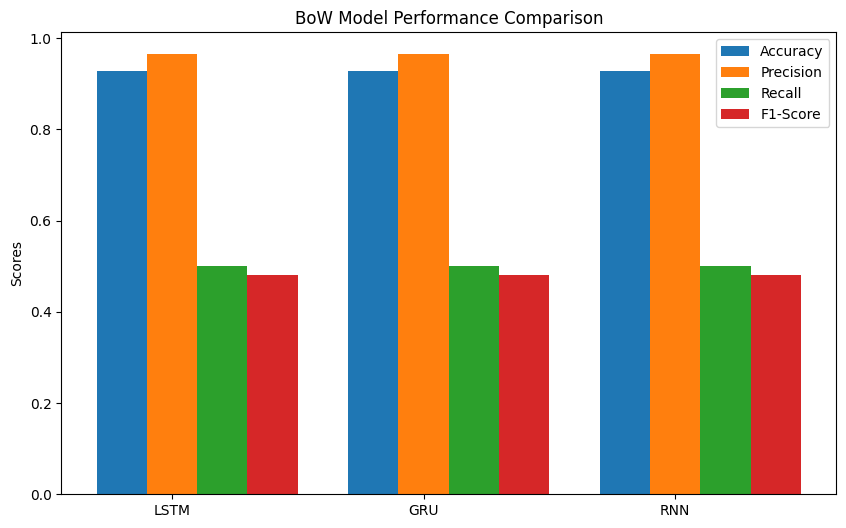

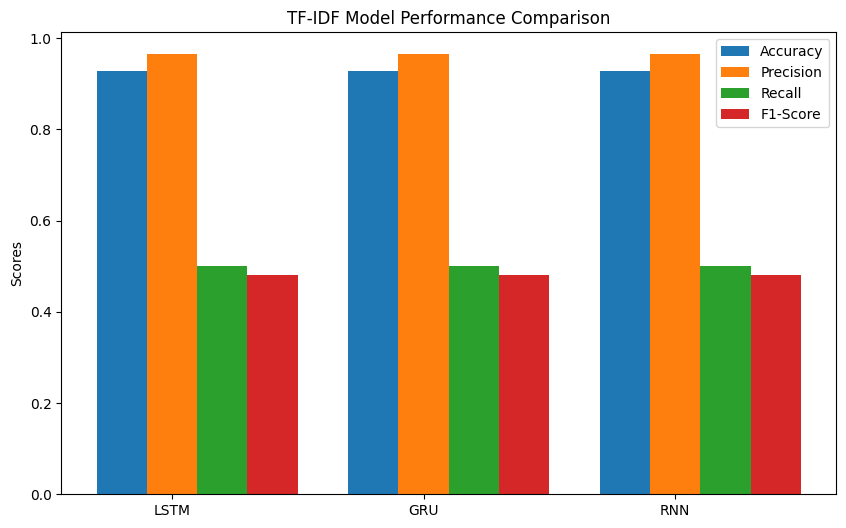

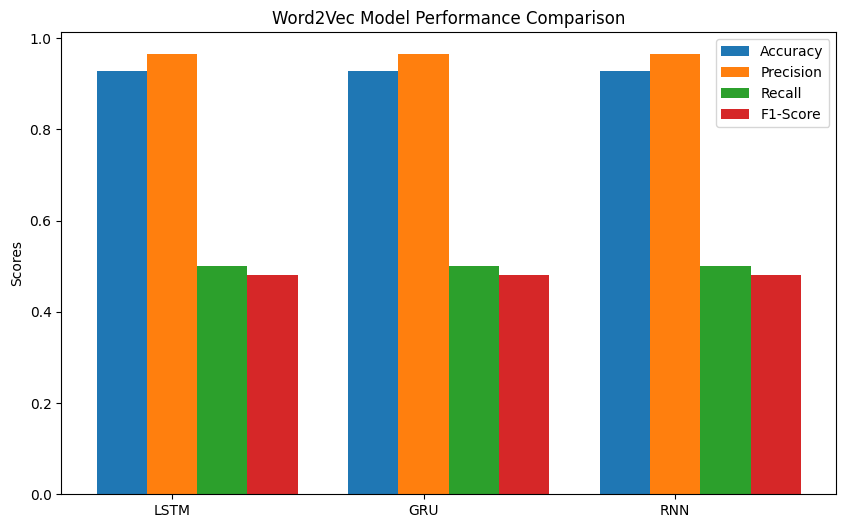

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Define the function to extract metrics
def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    return [accuracy, precision, recall, f1_score]

# Ensure proper padding of sequences for all datasets (BoW, TF-IDF, Word2Vec)
X_bow_train_padded = pad_sequences(X_bow_train, padding='post', maxlen=100)
X_bow_test_padded = pad_sequences(X_bow_test, padding='post', maxlen=100)

X_tfidf_train_padded = pad_sequences(X_tfidf_train, padding='post', maxlen=100)
X_tfidf_test_padded = pad_sequences(X_tfidf_test, padding='post', maxlen=100)

X_w2v_train_padded = pad_sequences(X_w2v_train, padding='post', maxlen=100)
X_w2v_test_padded = pad_sequences(X_w2v_test, padding='post', maxlen=100)

# BoW
lstm_bow_pred = (lstm_model.predict(X_bow_test_padded) > 0.5).astype(int)
gru_bow_pred = (gru_model.predict(X_bow_test_padded) > 0.5).astype(int)
rnn_bow_pred = (rnn_model.predict(X_bow_test_padded) > 0.5).astype(int)

metrics_bow = {
    'LSTM': extract_metrics(y_bow_test, lstm_bow_pred),
    'GRU': extract_metrics(y_bow_test, gru_bow_pred),
    'RNN': extract_metrics(y_bow_test, rnn_bow_pred),
}

# TF-IDF
lstm_tfidf_pred = (lstm_model.predict(X_tfidf_test_padded) > 0.5).astype(int)
gru_tfidf_pred = (gru_model.predict(X_tfidf_test_padded) > 0.5).astype(int)
rnn_tfidf_pred = (rnn_model.predict(X_tfidf_test_padded) > 0.5).astype(int)

metrics_tfidf = {
    'LSTM': extract_metrics(y_tfidf_test, lstm_tfidf_pred),
    'GRU': extract_metrics(y_tfidf_test, gru_tfidf_pred),
    'RNN': extract_metrics(y_tfidf_test, rnn_tfidf_pred),
}

# Word2Vec
lstm_w2v_pred = (lstm_model.predict(X_w2v_test_padded) > 0.5).astype(int)
gru_w2v_pred = (gru_model.predict(X_w2v_test_padded) > 0.5).astype(int)
rnn_w2v_pred = (rnn_model.predict(X_w2v_test_padded) > 0.5).astype(int)

metrics_w2v = {
    'LSTM': extract_metrics(y_w2v_test, lstm_w2v_pred),
    'GRU': extract_metrics(y_w2v_test, gru_w2v_pred),
    'RNN': extract_metrics(y_w2v_test, rnn_w2v_pred),
}

# Function to plot metrics
def plot_metrics(results, title):
    models = ['LSTM', 'GRU', 'RNN']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    ind = np.arange(len(models))  # the x locations for the groups
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        values = [results[model][i] for model in models]
        ax.bar(ind + i * width, values, width, label=metric)

    ax.set_ylabel('Scores')
    ax.set_title(f'{title} Model Performance Comparison')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(models)
    ax.legend()

# Plot performance comparison for BoW, TF-IDF, and Word2Vec
plot_metrics(metrics_bow, 'BoW')
plt.show()

plot_metrics(metrics_tfidf, 'TF-IDF')
plt.show()

plot_metrics(metrics_w2v, 'Word2Vec')
plt.show()


Enhancments

Using Pre-trained Word Embeddings (GloVe or FastText)


In [79]:
!#wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [80]:
from transformers import BertTokenizer
import numpy as np

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Tokenize your sentences using BERT tokenizer
sample_text = "This is an example sentence."
tokens = tokenizer.tokenize(sample_text)

# Prepare embedding matrix for the tokens
embedding_matrix = np.zeros((len(tokens), embedding_dim))

for i, word in enumerate(tokens):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Example: BERT token IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Now you can use token_ids for further processing in your model
print("Token IDs:", token_ids)
print("Embedding Matrix:", embedding_matrix)

Token IDs: [2023, 2003, 2019, 2742, 6251, 1012]
Embedding Matrix: [[-0.57058001  0.44183001  0.70102    -0.41712999 -0.34057999  0.02339
  -0.071537    0.48177001 -0.013121    0.16834    -0.13389     0.040626
   0.15827    -0.44341999 -0.019403   -0.009661   -0.046284    0.093228
  -0.27331001  0.22849999  0.33089    -0.36474001  0.078741    0.3585
   0.44757    -0.2299      0.18076999 -0.62650001  0.053852   -0.29154
  -0.42559999  0.62902999  0.14393    -0.046004   -0.21007     0.48879001
  -0.057698    0.37430999 -0.030075   -0.34494001 -0.29701999  0.15095
   0.28248    -0.16577999  0.076131   -0.093016    0.79364997 -0.60488999
  -0.18874    -1.01730001  0.31962001 -0.16344     0.54176998  1.17250001
  -0.47874999 -3.3842001  -0.081301   -0.35280001  1.83720005  0.44516
  -0.52666003  0.99786001 -0.32178     0.033462    1.17830002 -0.072905
   0.39737001  0.26166001  0.33111    -0.35629001 -0.16558    -0.44382
  -0.14183    -0.37976     0.28994    -0.029114   -0.35168999 -0.276939

Adding an Attention Mechanism

In [81]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[1]),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer="zeros", trainable=True)

    def call(self, inputs):
        attention_scores = tf.nn.softmax(tf.matmul(inputs, self.W) + self.b, axis=1)
        context_vector = tf.reduce_sum(attention_scores * inputs, axis=1)
        return context_vector

# Example RNN with Attention
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=X_bow_train.shape[1]))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(Attention())  # Apply attention layer
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Hyperparameter Tuning with Keras Tuner

In [82]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        hp.Int('units', min_value=32, max_value=64, step=32),
        input_shape=(X_bow_train.shape[1], 1),
        activation='relu'
    ))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

X_bow_train_reshaped = np.expand_dims(X_bow_train, axis=-1)
X_bow_test_reshaped = np.expand_dims(X_bow_test, axis=-1)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    factor=2,
    hyperband_iterations=1,
    directory='my_dir',
    project_name='rnn_tuning'
)

tuner.search(X_bow_train_reshaped, y_bow_train, epochs=3, validation_data=(X_bow_test_reshaped, y_bow_test))

Trial 8 Complete [00h 03m 28s]
val_accuracy: 0.9287894368171692

Best val_accuracy So Far: 0.9287894368171692
Total elapsed time: 00h 53m 42s


#Conclusion

In this Experiment, we focused on sentiment analysis of Amazon product reviews using deep learning techniques. We began by preprocessing the text data with methods such as Bag of Words (BoW), TF-IDF, and Word2Vec to transform the text into numerical representations. Various models, including Simple RNN, LSTM, and GRU, were trained on these feature representations, and their performance was evaluated using accuracy, precision, recall, and F1-score.

We visualized the results, comparing the performance of each model across the different feature representations. The comparison highlighted the impact of feature extraction methods on model performance. Additionally, we incorporated BERT, a pre-trained transformer model, for sentiment classification. After addressing compatibility issues with tokenization and embeddings, we successfully fine-tuned BERT using TensorFlow’s optimizer.

